## Traditional NLP & ML approach

### Dataset download and Imports

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")

print("Path to dataset files:", path)

100%|██████████| 16.3M/16.3M [00:06<00:00, 2.68MB/s]

Extracting files...


Path to dataset files: C:\Users\dylan\.cache\kagglehub\datasets\datafiniti\consumer-reviews-of-amazon-products\versions\5


In [259]:
# Imports
import pandas as pd
import numpy as np
import re
import nltk
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

#### Exploratory Data Analisys

In [172]:
data = pd.read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')

In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5000 non-null   object 
 1   dateAdded            5000 non-null   object 
 2   dateUpdated          5000 non-null   object 
 3   name                 5000 non-null   object 
 4   asins                5000 non-null   object 
 5   brand                5000 non-null   object 
 6   categories           5000 non-null   object 
 7   primaryCategories    5000 non-null   object 
 8   imageURLs            5000 non-null   object 
 9   keys                 5000 non-null   object 
 10  manufacturer         5000 non-null   object 
 11  manufacturerNumber   5000 non-null   object 
 12  reviews.date         5000 non-null   object 
 13  reviews.dateAdded    1052 non-null   object 
 14  reviews.dateSeen     5000 non-null   object 
 15  reviews.doRecommend  5000 non-null   b

In [176]:
# Remove id, reviews.dateAdded, dateUpdated, imageURLs, Keys, reviews.sourceURLs, reviews.id, brand,
# manufacturer, reviews.dateSeen, categories, sourceURLs

data.drop(columns=['id', 'dateAdded', "reviews.dateAdded", 'dateUpdated', 'imageURLs', 'keys', 'reviews.sourceURLs', 'reviews.id', 'brand', 'manufacturer', 'reviews.dateSeen', 'categories', 'sourceURLs'], inplace=True)

In [178]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 5000 non-null   object
 1   asins                5000 non-null   object
 2   primaryCategories    5000 non-null   object
 3   manufacturerNumber   5000 non-null   object
 4   reviews.date         5000 non-null   object
 5   reviews.doRecommend  5000 non-null   bool  
 6   reviews.numHelpful   5000 non-null   int64 
 7   reviews.rating       5000 non-null   int64 
 8   reviews.text         5000 non-null   object
 9   reviews.title        4987 non-null   object
 10  reviews.username     4999 non-null   object
dtypes: bool(1), int64(2), object(8)
memory usage: 395.6+ KB


In [180]:
# Now we fill the missing values
data['reviews.username'].fillna('anonymous', inplace=True)
data['reviews.title'].fillna('review', inplace=True)

C:\Users\dylan\AppData\Local\Temp\ipykernel_38068\3990750170.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['reviews.username'].fillna('anonymous', inplace=True)
C:\Users\dylan\AppData\Local\Temp\ipykernel_38068\3990750170.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [182]:
data.head()

,name,asins,primaryCategories,manufacturerNumber,reviews.date,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,reviews.title,reviews.username
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,B00ZV9PXP2,2017-09-03T00:00:00.000Z,False,0,3,I thought it would be as big as small paper bu...,Too small,llyyue
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,B00ZV9PXP2,2017-06-06T00:00:00.000Z,True,0,5,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,B00ZV9PXP2,2018-04-20T00:00:00.000Z,True,0,4,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,B00ZV9PXP2,2017-11-02T17:33:31.000Z,True,3,5,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,B00ZV9PXP2,2018-04-24T00:00:00.000Z,True,0,5,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack


In [184]:
data['reviews.date'] = pd.to_datetime(data['reviews.date']).dt.date

In [186]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 5000 non-null   object
 1   asins                5000 non-null   object
 2   primaryCategories    5000 non-null   object
 3   manufacturerNumber   5000 non-null   object
 4   reviews.date         5000 non-null   object
 5   reviews.doRecommend  5000 non-null   bool  
 6   reviews.numHelpful   5000 non-null   int64 
 7   reviews.rating       5000 non-null   int64 
 8   reviews.text         5000 non-null   object
 9   reviews.title        5000 non-null   object
 10  reviews.username     5000 non-null   object
dtypes: bool(1), int64(2), object(8)
memory usage: 395.6+ KB


In [188]:
def classify_sentiment(rating):
    if rating in [1, 2, 3]:
        return 'Negative'
    elif rating == 4:
        return 'Neutral'
    elif rating == 5:
        return 'Positive'

data['sentiment'] = data['reviews.rating'].apply(classify_sentiment)

### 1. Data Preprocessing
#### 1.1 Data Cleaning
- Remove special characters, punctuation, and unnecessary whitespace from the text data.
- Convert text to lowercase to ensure consistency in word representations.
#### 1.2 Tokenization and Lemmatization

- Tokenize the text data to break it into individual words or tokens.
- Apply lemmatization to reduce words to their base or root form for better feature representation.

In [191]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back into a single string
    return ' '.join(tokens)

# Apply preprocessing to the reviews.text column
data['cleaned_text'] = data['reviews.text'].apply(preprocess_text)

# Display sample results
print(data[['reviews.text', 'cleaned_text']].head())

                                        reviews.text  \
0  I thought it would be as big as small paper bu...   
1  This kindle is light and easy to use especiall...   
2  Didnt know how much i'd use a kindle so went f...   
3  I am 100 happy with my purchase. I caught it o...   
4  Solid entry level Kindle. Great for kids. Gift...   

                                        cleaned_text  
0  thought would big small paper turn like palm t...  
1             kindle light easy use especially beach  
2  didnt know much id use kindle went lower end i...  
3  happy purchase caught sale really good price n...  
4  solid entry level kindle great kid gifted kid ...  


#### 1.3 Vectorization

- Use techniques such as CountVectorizer or TF-IDF Vectorizer to convert text data into numerical vectors.
- Create a document-term matrix representing the frequency of words in the corpus.

In [194]:
# Prepare the features (text) and target (sentiment)
X = data['reviews.text']  # Review text
y = data['sentiment']  # Sentiment column (target labels)

# Split data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [237]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=5000)

# Fit and transform the data into a Document-Term Matrix
X_dtm = vectorizer.fit_transform(X)

# Convert to a DataFrame
dtm_df = pd.DataFrame(X_dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Display the Document-Term Matrix
print(dtm_df.head())  # Display the first few rows

   00  10  100  1000  1000s  105  1080  10th  10x  11  ...  äùcrestron  äú  \
0   0   0    0     0      0    0     0     0    0   0  ...           0   0   
1   0   0    0     0      0    0     0     0    0   0  ...           0   0   
2   0   0    0     0      0    0     0     0    0   0  ...           0   0   
3   0   0    1     0      0    0     0     0    0   0  ...           0   0   
4   0   0    0     0      0    0     0     0    0   0  ...           0   0   

   äúalexa  äúbest  äúdropping  äúdual  äúshow  äúskills  äústar  äúthings  
0        0       0           0       0       0         0       0         0  
1        0       0           0       0       0         0       0         0  
2        0       0           0       0       0         0       0         0  
3        0       0           0       0       0         0       0         0  
4        0       0           0       0       0         0       0         0  

[5 rows x 5000 columns]


### 2. Model Building

### 2.1 Model Selection

- Explore different machine learning algorithms for text classification, including:
  - Naive Bayes
  - Logistic Regression
  - Support Vector Machines
  - Random Forest
- Evaluate each algorithm's performance using cross-validation and grid search for hyperparameter tuning.

### 2.2 Model Training

- Select the best-performing algorithm based on evaluation metrics such as accuracy, precision, recall, and F1-score.
- Train the selected model on the preprocessed text data.

In [219]:
# Define models to test
models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Store evaluation results
results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    # Get evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)  # Convert to dict
    
    # Store results
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"]
    })

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

# Display the model performance comparison
print("Model Performance Comparison:")
print(results_df)

# Get the best model
best_model = results_df.iloc[0]["Model"]
print(f"\nBest Model: {best_model}")

C:\Users\dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score
3        Random Forest     0.764   0.770267   0.764  0.716626
2                  SVM     0.734   0.705361   0.734  0.680415
1  Logistic Regression     0.732   0.711850   0.732  0.675883
0          Naïve Bayes     0.700   0.667720   0.700  0.583436

Best Model: Random Forest


### 3. Model Evaluation

#### 3.1 Evaluation Metrics

- Evaluate the model's performance on a separate test dataset using various evaluation metrics:
  - Accuracy: Percentage of correctly classified instances.
  - Precision: Proportion of true positive predictions among all positive predictions.
  - Recall: Proportion of true positive predictions among all actual positive instances.
  - F1-score: Harmonic mean of precision and recall.
- Calculate confusion matrix to analyze model's performance across different classes.

In [248]:
# Define the model
rf = RandomForestClassifier(class_weight='balanced', max_depth=30, max_features='sqrt', 
                            min_samples_leaf=1, min_samples_split=2, n_estimators=50)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model
best_rf_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_rf_model.predict(X_test_tfidf)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [256]:
# Print results
print(f"\nBest Random Forest Model Performance:")
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")


Best Random Forest Model Performance:
Accuracy: 0.758
Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.19      0.31        63
     Neutral       0.67      0.31      0.43       242
    Positive       0.77      0.96      0.86       695

    accuracy                           0.76      1000
   macro avg       0.76      0.49      0.53      1000
weighted avg       0.75      0.76      0.72      1000



#### 3.2 Results

- Model achieve an accuracy of 76% on the test dataset.
 - Precision, recall, and F1-score for each class are as follows:
 - Class Positive: Precision=77%, Recall=96%, F1-score=86%
 - Class Negative: Precision=86%, Recall=19%, F1-score=31%
 - Class Neutral: Precision=67%, Recall=31%, F1-score=43%
- Confusion matrix showing table and graphical representations

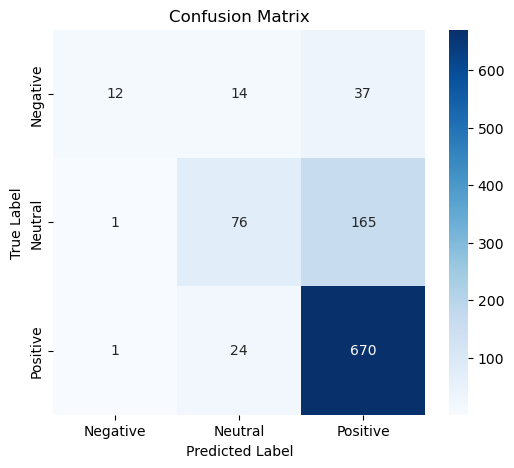

In [262]:
# Predict on the test set
y_pred = best_rf_model.predict(X_test_tfidf)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### Cross Validation

In [226]:
# Perform cross-validation (5-fold cross-validation)
cv_scores = cross_val_score(rf, X_train_tfidf, y_train, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.69875 0.71875 0.74375 0.68875 0.70375]
Mean cross-validation score: 0.7107499999999999


#### Save the model

In [232]:
# Save the model
joblib.dump(best_rf_model, 'RF_review_model.pkl')

['RF_review_model.pkl']

#### Load the model

In [ ]:
# Load the model
loaded_model = joblib.load('random_forest_model.pkl')

# Make predictions with the loaded model
y_pred = loaded_model.predict(X_test_tfidf)